# Crypto Portfolio Selection 

In [1]:
import jax
import jax.numpy as jnp
import polars as pl
import polars.selectors as cs

# Load data

In [2]:
import pandas as pd
import yfinance as yf

data: pd.DataFrame = yf.download("BTC-USD ETH-USD", start="2022-01-01", end="2024-01-01")["Close"].dropna()

[*********************100%***********************]  2 of 2 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

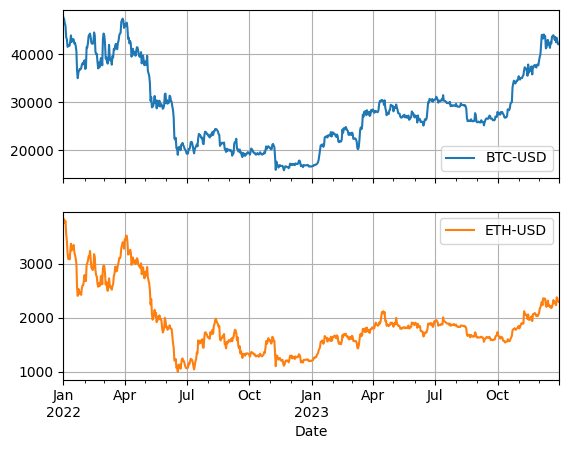

In [3]:
data.plot(grid=True, subplots=True)

In [4]:
df_returns = (
    pl.from_dataframe(data.reset_index()) 
    .select(
        cs.datetime(),
        pl.col("BTC-USD").pct_change(),
        pl.col("ETH-USD").pct_change(),
    )
    .drop_nulls()
)
df_returns

Date,BTC-USD,ETH-USD
"datetime[ns, UTC]",f64,f64
2022-01-02 00:00:00 UTC,-0.007163,0.015881
2022-01-03 00:00:00 UTC,-0.018737,-0.017805
2022-01-04 00:00:00 UTC,-0.012066,0.008687
2022-01-05 00:00:00 UTC,-0.050734,-0.064224
2022-01-06 00:00:00 UTC,-0.009366,-0.037173
…,…,…
2023-12-27 00:00:00 UTC,0.021694,0.065999
2023-12-28 00:00:00 UTC,-0.01876,-0.013105
2023-12-29 00:00:00 UTC,-0.012397,-0.019968


# Offline portfolio

In [5]:
from pyfoliopt.benchmark import best_kelly_portfolio


returns = jnp.array(
    df_returns.to_numpy()[:, 1:]
)

long_only = best_kelly_portfolio(returns)
long_short = best_kelly_portfolio(returns, short_selling=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


<Axes: xlabel='Date'>

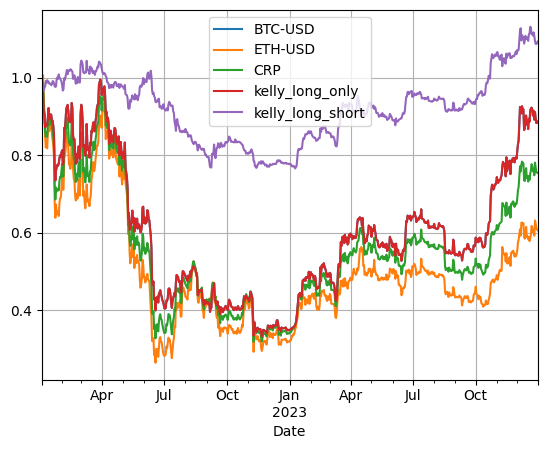

In [6]:
(
    df_returns
    .with_columns(
        CRP = pl.col("BTC-USD") * 0.5 + pl.col("ETH-USD") * 0.5,
        kelly_long_only = pl.col("BTC-USD") * long_only[0] + pl.col("ETH-USD") * long_only[1],
        kelly_long_short = pl.col("BTC-USD") * long_short[0] + pl.col("ETH-USD") * long_short[1],
    )
    .select(cs.datetime(), cs.numeric().add(1).cum_prod())
    .to_pandas()
    .set_index("Date")
    .plot(grid=True)
)

In [7]:
long_short

Array([ 0.6204711, -0.3795289], dtype=float32)

# Online portfolio

## Long/short portfolio

In [15]:
import optax
from pyfoliopt.optimizer import proj_gd
from pyfoliopt.projection import projection_l1_ball
from pyfoliopt.loss import kelly_loss

lr = 1e-2
optimizer = proj_gd(lr, projection_l1_ball)
opt_state = optimizer.init(returns[0])

In [17]:
loss_fn = jax.vmap(kelly_loss, in_axes=(None, 0))

In [16]:
# @jax.jit
def step(params, returns, state):
    loss, grad = jax.value_and_grad(loss_fn)(params, returns)
    updates, state = optimizer.update(grad, state, params)
    params = optax.apply_updates(params, updates)
    return params, state, loss

params = jnp.array([0.0, 0.0])

for i in range(1000):
    params, opt_state, loss = step(params, returns, opt_state)
    print(f"Step {i}: loss={loss}, params={params}")

Step 0: loss=-0.0, params=[-0.07163275  0.15881361]
Step 1: loss=0.0014865712728351355, params=[-0.25928026 -0.01949911]
Step 2: loss=-0.0029546436853706837, params=[-0.37957984  0.06711768]
Step 3: loss=-0.014836450107395649, params=[-0.6568922  -0.34310788]
Step 4: loss=-0.018730437383055687, params=[-0.5204376  -0.47956246]
Step 5: loss=-0.049667906016111374, params=[-0.38371354 -0.6162865 ]
Step 6: loss=-0.01775478757917881, params=[-0.20717552 -0.79282445]
Step 7: loss=0.01790792867541313, params=[-0.16383661 -0.5762398 ]
Step 8: loss=-0.013879450038075447, params=[-0.18509436 -0.8093949 ]
Step 9: loss=0.045774929225444794, params=[ 0.04383996 -0.2830596 ]
Step 10: loss=0.010537154972553253, params=[0.33074138 0.13560328]
Step 11: loss=0.01531787309795618, params=[ 0.0170863  -0.23768753]
Step 12: loss=0.0043211826123297215, params=[ 0.13690564 -0.04687893]
Step 13: loss=4.392958726384677e-05, params=[0.15493423 0.01514581]
Step 14: loss=0.00013519247295334935, params=[0.14022094 